In [418]:
import warnings
warnings.filterwarnings('ignore')

In [419]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import skimage.exposure
from skimage import measure

In [420]:
def image_fill(Binary_image):
    # Mask used to flood filling.
    im_th=Binary_image.astype('uint8').copy()
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 1);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    im_out[im_out==254]=0
    return im_out

In [6]:
# Sort bounding rects by x coordinate
def getXFromRect(item):
    return item[0]

In [445]:
def draw_rectangle(contours, image, templateT, templateC):

  # Array of initial bounding rects
  rects = []

  # Bool array indicating which initial bounding rect has
  # already been used
  rectsUsed = []

  mask = get_mask(templateT)
  T = cv2.bitwise_and(templateT, templateT, mask = mask)

  mask = get_mask(templateC)
  C = cv2.bitwise_and(templateC, templateC, mask = mask)

  for contour in contours:
    area = cv2.contourArea(contour)
    if(area > 100):
      rects.append(cv2.boundingRect(contour))
      rectsUsed.append(False)

  rects.sort(key = getXFromRect)

  # Array of accepted rects
  acceptedRects = []

  # Merge threshold for x coordinate distance
  xThr = 5

  # Iterate all initial bounding rects
  for supIdx, supVal in enumerate(rects):
    if (rectsUsed[supIdx] == False):

        # Initialize current rect
        currxMin = supVal[0]
        currxMax = supVal[0] + supVal[2]
        curryMin = supVal[1]
        curryMax = supVal[1] + supVal[3]

        # This bounding rect is used
        rectsUsed[supIdx] = True

        # Iterate all initial bounding rects
        # starting from the next
        for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):

            # Initialize merge candidate
            candxMin = subVal[0]
            candxMax = subVal[0] + subVal[2]
            candyMin = subVal[1]
            candyMax = subVal[1] + subVal[3]

            # Check if x distance between current rect
            # and merge candidate is small enough
            if (candxMin <= currxMax + xThr):

                # Reset coordinates of current rect
                currxMax = candxMax
                curryMin = min(curryMin, candyMin)
                curryMax = max(curryMax, candyMax)

                # Merge candidate (bounding rect) is used
                rectsUsed[subIdx] = True
            else:
                break

        # No more merge candidates possible, accept current rect
        acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])
  
  for rect in acceptedRects:

    # The (x,y) point of the left corner 
    x, y = (rect[0] - rect[2]//5, rect[1] - rect[3]//5)
    w, h = (rect[0] + rect[2] + rect[2]//7, rect[1] + rect[3] +  rect[3]//7)

    #get the corresponding part of the image 
    im = image[y : h,x : w, :]

    if (im.shape[0] > 0 and im.shape[0]< image.shape[0]) and (im.shape[1] > 0 and im.shape[1] < image.shape[1]):

      C = cv2.resize(C, (im.shape[1], im.shape[0]))
      T = cv2.resize(T, (im.shape[1], im.shape[0]))
      # cv2_imshow(C)
      # cv2_imshow(T)
      
      # get the mask of the extracted part 
      im = cv2.medianBlur(im, 5)
      mask = get_mask(im)
      im = cv2.bitwise_and(im, im, mask = mask)
      # cv2_imshow(im)
      
      # Calculate mse between the cropped image and templates
      mseT = np.mean(np.square(T - im))
      mseC = np.mean(np.square(C - im))
      mse = np.min([mseT, mseC])

      # Calculate ssim between the cropped image and templates
      ssimT = measure.compare_ssim(T, im, multichannel=True)
      ssimC = measure.compare_ssim(C, im, multichannel=True)
      ssim = np.max([ssimT, ssimC])

      # print('MSE C', mseC)
      # print('MSE T', mseT)
      # print('SSIM C', ssimC)
      # print('SSIM T', ssimT)

      # Draw bounding box if similarity is above thresholds
      if ssim > 0.5 or mse < 55 and not(ssim < 0.4):
        img = cv2.rectangle(image,
                            (x, y),
                            (w, h), (0, 0, 255), 2)
            
  return image

In [446]:
def get_mask(image, op = 'and'):

  # Enhance the image and get the hsv format
  image = skimage.exposure.rescale_intensity(image, in_range=(20,200), out_range=(0,255))
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  
  # maks to filter yellow color in the image
  yellow_lower = np.array([10, 100, 90], np.uint8)
  yellow_upper = np.array([30, 255, 255], np.uint8)
  yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
  yellow_mask = image_fill(yellow_mask)

  
  # Mask to filter red color from the image
  red_lower = np.array([0, 120, 50], np.uint8)
  red_upper = np.array([10, 255, 255], np.uint8)
 
  qred_lower = np.array([170, 70, 50], np.uint8)
  qred_upper = np.array([180, 255, 255], np.uint8)
 
  red_maskx = cv2.inRange(hsv, red_lower, red_upper)
  red_masky = cv2.inRange(hsv, qred_lower, qred_upper)
  red_mask = red_maskx | red_masky
  red_mask = image_fill(red_mask)
  

  # Final mask for red and yellow
  if op == 'and':
    mask = yellow_mask & red_mask
  else: 
    mask = yellow_mask | red_mask
  
  # Remove noise and fill the gaps
  mask = cv2.medianBlur(mask, 7)
  mask = image_fill(mask)
  mask = cv2.medianBlur(mask, 7)
  mask = image_fill(mask)

  return mask

In [447]:
def detect_signs(image, templateT, templateC):
 
 # Get the mask of the signs
  mask = get_mask(image)
  res = cv2.bitwise_and(image, image, mask = mask)

  # Get the signs contours 
  contours, hierarchy = cv2.findContours(mask,
                                        cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)
  #Draw the bounding box 
  image = draw_rectangle(contours, image, templateT, templateC)
  cv2_imshow(image)

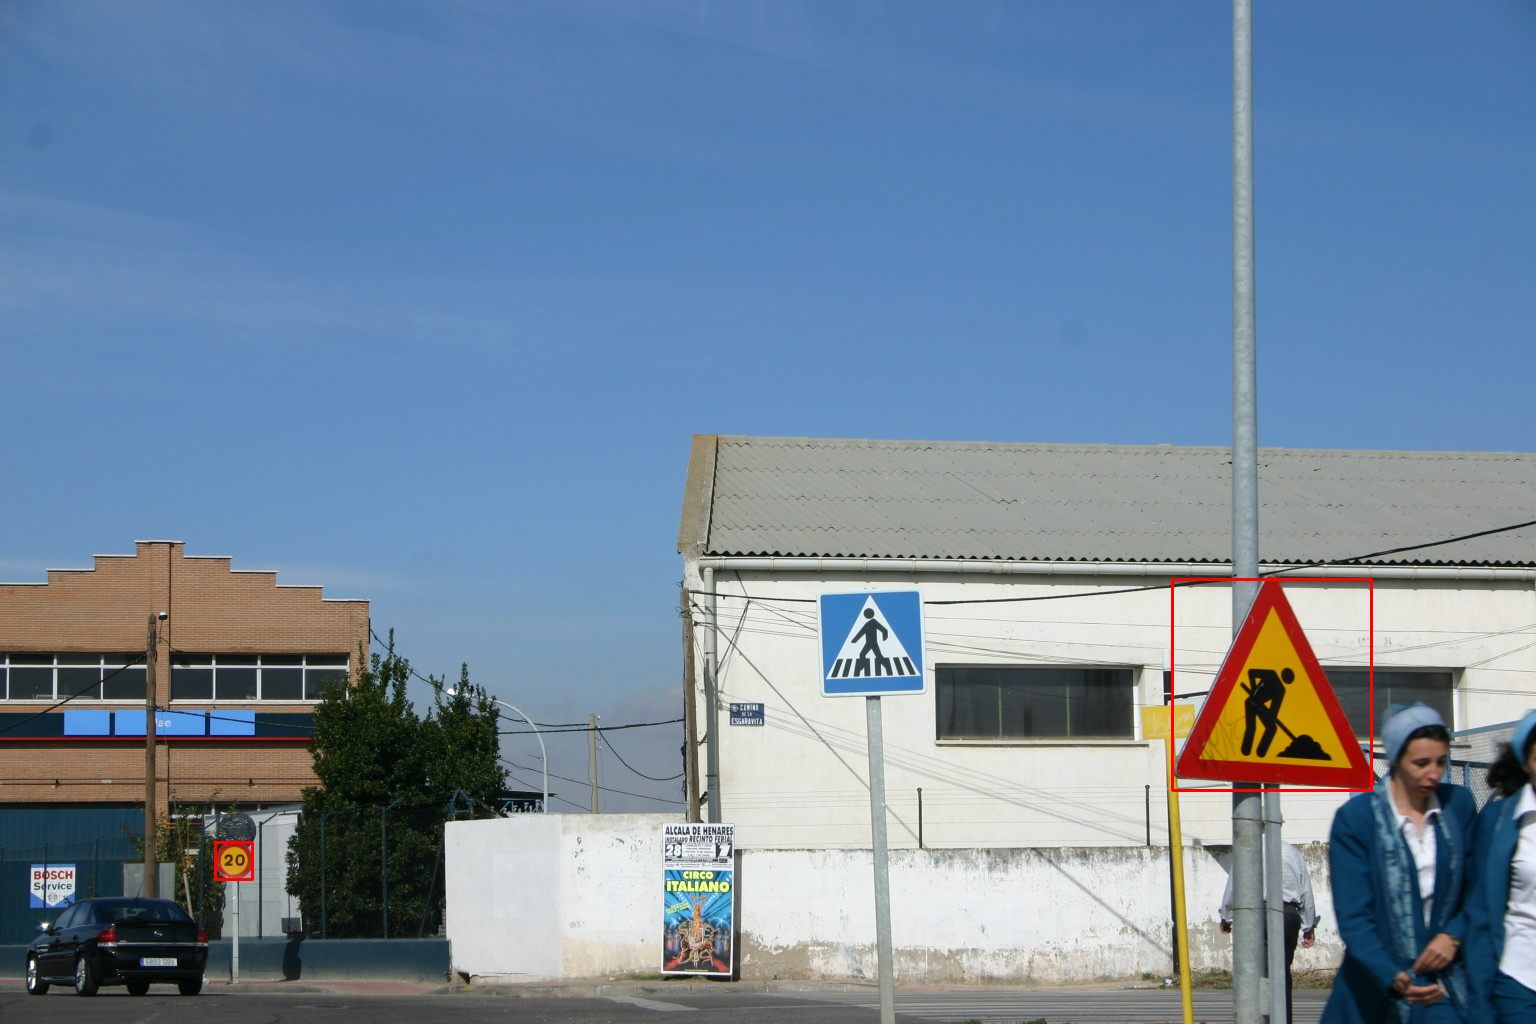

In [448]:
image_path = '/content/Am_Rojo0004.jpg'
templateT_path = '/content/tempT.PNG'
templateC_path = '/content/tempC.PNG'

image = cv2.imread(image_path)
templateT =cv2.imread(templateT_path) # Triangular template
templateC =cv2.imread(templateC_path) # Circular Template

# Detect the signs
detect_signs(image, templateT, templateC)